## 4. Data Preparation

### Import the necessary packages

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Import the CSV data as Pandas DataFrame

In [2]:
df = pd.read_csv('data/EasyVisa.csv')
df.shape

(25480, 12)

### Show the first 5 records of the dataset

In [3]:
df.head().T

,0,1,2,3,4
case_id,EZYV01,EZYV02,EZYV03,EZYV04,EZYV05
continent,Asia,Asia,Asia,Asia,Africa
education_of_employee,High School,Master's,Bachelor's,Bachelor's,Master's
has_job_experience,N,Y,N,N,Y
requires_job_training,N,N,Y,N,N
no_of_employees,14513,2412,44444,98,1082
yr_of_estab,2007,2002,2008,1897,2005
region_of_employment,West,Northeast,West,West,South
prevailing_wage,592.2029,83425.65,122996.86,83434.03,149907.39
unit_of_wage,Hour,Year,Year,Year,Year


In [4]:
# Remove outliers
df = df[df['prevailing_wage'] >= 7.25]
df.shape

(25469, 12)

In [5]:
df[df['no_of_employees'] <= 0].shape

(33, 12)

In [6]:
df = df[df['no_of_employees'] > 0]
df.shape

(25436, 12)

### Drop `case_id` column from the dataset

In [7]:
# Remove the column
del df['case_id']
df.shape

(25436, 11)

### Encode target variable for classification

In [8]:
df.case_status.head()

0       Denied
1    Certified
2       Denied
3       Denied
4    Certified
Name: case_status, dtype: object

In [9]:
# Replace Certified/Denied with a number; 1 (Cerified) or 0 (Denied)
df.case_status = (df.case_status == 'Certified').astype(int)
df.case_status[:5]

0    0
1    1
2    0
3    0
4    1
Name: case_status, dtype: int32

### Set up the validation framework

#### Prepare the $X$ feature matrix and the $y$ target variable

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# Perform the train/validation/test split with Scikit-Learn
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.case_status.values
y_val = df_val.case_status.values
y_test = df_test.case_status.values

del df_train['case_status']
del df_val['case_status']
del df_test['case_status']

In [12]:
df_train.shape, df_val.shape, df_test.shape

((15261, 10), (5087, 10), (5088, 10))

In [13]:
df_train.head().T

,0,1,2,3,4
continent,Asia,Asia,Asia,Asia,Asia
education_of_employee,Bachelor's,Bachelor's,Master's,Bachelor's,Master's
has_job_experience,N,N,N,Y,N
requires_job_training,N,N,N,N,N
no_of_employees,2500,1527,5380,3035,546
yr_of_estab,1971,2013,1998,1907,2014
region_of_employment,Northeast,South,West,West,South
prevailing_wage,105.87,38764.07,37037.67,89891.32,149133.36
unit_of_wage,Hour,Year,Year,Year,Year
full_time_position,Y,Y,Y,N,Y


In [14]:
y_train[:5]

array([1, 0, 0, 1, 1])

In [15]:
print("Percentage of classes in training set:")
print(pd.DataFrame(y_train, columns=['case_status']).value_counts(normalize=True).round(4) * 100)

print("Percentage of classes in validation set:")
print(pd.DataFrame(y_val, columns=['case_status']).value_counts(normalize=True).round(4) * 100)

Percentage of classes in training set:
case_status
1              67.07
0              32.93
Name: proportion, dtype: float64
Percentage of classes in validation set:
case_status
1              66.58
0              33.42
Name: proportion, dtype: float64


In [16]:
numerical = df_train.select_dtypes(exclude="object").columns
categorical = df_train.select_dtypes(include="object").columns

In [17]:
numerical

Index(['no_of_employees', 'yr_of_estab', 'prevailing_wage'], dtype='object')

In [18]:
categorical

Index(['continent', 'education_of_employee', 'has_job_experience',
       'requires_job_training', 'region_of_employment', 'unit_of_wage',
       'full_time_position'],
      dtype='object')

### Feature Importance Analysis

This step aims to determine the most influential factors in predicting the visa application outcome.

#### Calculate Certify Rate and Risk Ratio
These metrics help assess the association between categorical features and the target variable:
- **Certify Rate:** 
  * Calculated as the proportion of certified cases within a specific category of a feature. 
  * A higher certify rate (diff $> 0$) within a category suggests a greater likelihood of certification for that category.
  * The difference between a category's certify rate and the overall certification rate provides an indication of the category's association with the target variable. 
  * Larger differences generally signify stronger associations.
- **Risk Ratio:** 
  * Calculated as the ratio of the probability of certification within a specific category to the overall probability of certification.
  * A risk ratio greater than 1 indicates that the category is more likely to be certified compared to the overall average. 
  * A risk ratio less than 1 indicates a lower likelihood of certification for that category. 
  * Risk ratios provide a relative measure of the association between a category and the target variable.

In [19]:
# Calculate the certify rate of the entire full train dataset
global_certify_rate = df_full_train.case_status.mean()
round(global_certify_rate, 2)

0.67

In [20]:
from IPython.display import display

In [21]:
# Calculate the difference and risk for all categorical variables
for c in categorical:
    print(c)
    df_group = df_full_train.groupby(c).case_status.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_certify_rate
    df_group['risk'] = df_group['mean'] / global_certify_rate
    display(df_group)
    print()
    print()

continent


,mean,count,diff,risk
continent,,,,
Africa,0.704225,426,0.034774,1.051944
Asia,0.655190,13506,-0.014261,0.978697
Europe,0.792256,2970,0.122804,1.183440
North America,0.624667,2627,-0.044785,0.933103
Oceania,0.640000,150,-0.029452,0.956006
South America,0.572496,669,-0.096955,0.855172




education_of_employee


,mean,count,diff,risk
education_of_employee,,,,
Bachelor's,0.624189,8169,-0.045263,0.932389
Doctorate,0.867435,1735,0.197984,1.295740
High School,0.343601,2727,-0.325851,0.513258
Master's,0.788001,7717,0.118549,1.177084




has_job_experience


,mean,count,diff,risk
has_job_experience,,,,
N,0.562215,8559,-0.107236,0.839815
Y,0.747307,11789,0.077855,1.116297




requires_job_training


,mean,count,diff,risk
requires_job_training,,,,
N,0.667928,17966,-0.001523,0.997725
Y,0.680940,2382,0.011489,1.017162




region_of_employment


,mean,count,diff,risk
region_of_employment,,,,
Island,0.590759,303,-0.078692,0.882452
Midwest,0.759977,3458,0.090525,1.135223
Northeast,0.635173,5726,-0.034279,0.948796
South,0.702804,5599,0.033353,1.049821
West,0.616306,5262,-0.053146,0.920613




unit_of_wage


,mean,count,diff,risk
unit_of_wage,,,,
Hour,0.344425,1713,-0.325027,0.514488
Month,0.557143,70,-0.112309,0.832238
Week,0.625000,216,-0.044452,0.933600
Year,0.700747,18349,0.031295,1.046747




full_time_position


,mean,count,diff,risk
full_time_position,,,,
N,0.691667,2160,0.022215,1.033184
Y,0.666813,18188,-0.002638,0.996059


#### Calculate Mutual Information 
Mutual Information (MI) measures the amount of information one variable provides about another. 

We will rank the features based on their MI scores. The feature with the highest MI score is considered the most important, followed by the feature with the second-highest score, and so on. 

In [22]:
from sklearn.metrics import mutual_info_score

In [23]:
def mutual_info_certify_score(series):
    return mutual_info_score(series, df_full_train.case_status)

In [24]:
# Calculate mutual information scores of all categorical variables
mi = df_full_train[categorical].apply(mutual_info_certify_score)
# Sort the result such that the most important features come first
mi.sort_values(ascending=False)

education_of_employee    0.053302
unit_of_wage             0.020692
has_job_experience       0.018769
continent                0.007012
region_of_employment     0.006578
full_time_position       0.000134
requires_job_training    0.000040
dtype: float64

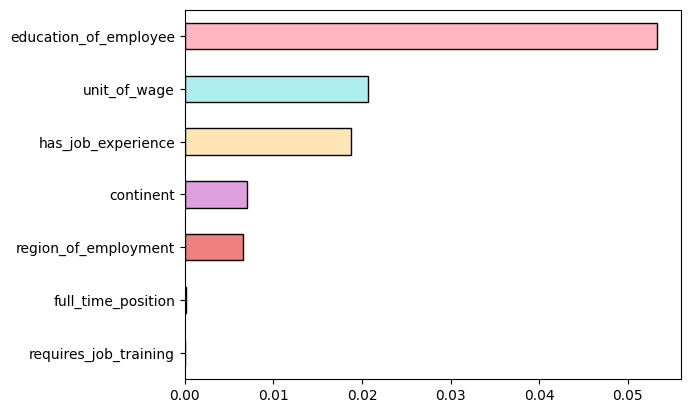

In [25]:
# Plot the bar graph
mi.nlargest(20).plot(kind='barh', ec='black', color=['lightpink', 'paleturquoise', 'moccasin', 'plum', 'lightcoral', 'sandybrown']).invert_yaxis()

**Top 5 Features:** 
* Based on Mutual Information (MI) scores, the top 5 categorical features for inclusion in the model are:
    1. `education_of_employee` (MI: 0.052196)
    2. `unit_of_wage` (MI: 0.020227)
    3. `has_job_experience` (MI: 0.017954)
    4. `continent` (MI: 0.007389)
    5. `region_of_employment` (MI: 0.006231)

**Feature Exclusion:**
* `full_time_position` has a very low MI score (0.000091), suggesting limited predictive power. Consider excluding it from the model.
* The MI score for `requires_job_training` (0.000004) is extremely low, confirming our earlier finding of no significant association with the target variable using the Chi-Square Test of Independence. This feature will be excluded from the model.

#### Calculate Correlation Coefficient

The Pearson correlation coefficient measures the linear relationship between two continuous variables. It can be used to assess the strength and direction of the linear relationship between numerical features and the binary target variable.

In [26]:
df_full_train[numerical].corrwith(df_full_train.case_status)

no_of_employees    0.010961
yr_of_estab        0.008774
prevailing_wage    0.078885
dtype: float64

Based on the correlation coefficient score of 0.075117 for `prevailing_wage`, we can infer a weak positive correlation between prevailing wage and the likelihood of visa certification by the OFLC.

In [27]:
# Rank the importance of each numerical features
corr_scores_abs = df_full_train[numerical].corrwith(df_full_train.case_status).abs().sort_values(ascending=False)
corr_scores_abs

prevailing_wage    0.078885
no_of_employees    0.010961
yr_of_estab        0.008774
dtype: float64

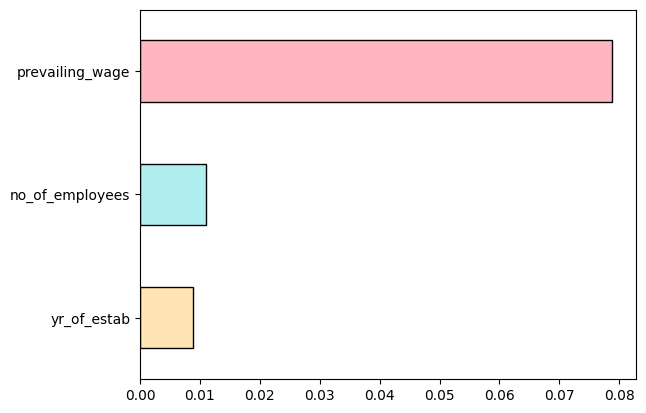

In [28]:
# Plot the bar graph
corr_scores_abs.nlargest(20).plot(kind='barh', ec='black', color=['lightpink', 'paleturquoise', 'moccasin']).invert_yaxis()

**Observation:** `prevailing_wage` emerged as the most important numerical feature, followed by `yr_of_estab` and then `no_of_employees` in predicting visa application approval. 

### Baseline Model

In [29]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [30]:
numerical

Index(['no_of_employees', 'yr_of_estab', 'prevailing_wage'], dtype='object')

In [31]:
categorical

Index(['continent', 'education_of_employee', 'has_job_experience',
       'requires_job_training', 'region_of_employment', 'unit_of_wage',
       'full_time_position'],
      dtype='object')

In [37]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[list(categorical) + list(numerical)].to_dict(orient='records')
X_train_baseline = dv.fit_transform(train_dict)

val_dict = df_val[list(categorical) + list(numerical)].to_dict(orient='records')
X_val_baseline = dv.transform(val_dict)

model = LogisticRegression()
model.fit(X_train_baseline, y_train)

y_pred = model.predict_proba(X_val_baseline)[:, 1]
approval_outcome = (y_pred >= 0.5)
(y_val == approval_outcome).mean()

0.7328484371928445

Our baseline logistic regression model achieved an accuracy of 73.3%.

In [38]:
thresholds = np.linspace(0, 1, 21)
scores = []

for t in thresholds:
    approval_outcome = (y_pred >= t)
    score = (y_val == approval_outcome).mean()
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.666
0.05 0.666
0.10 0.668
0.15 0.672
0.20 0.686
0.25 0.689
0.30 0.694
0.35 0.703
0.40 0.711
0.45 0.725
0.50 0.733
0.55 0.737
0.60 0.731
0.65 0.695
0.70 0.664
0.75 0.657
0.80 0.594
0.85 0.507
0.90 0.438
0.95 0.340
1.00 0.334


Text(0.5, 0, 'Threshold')

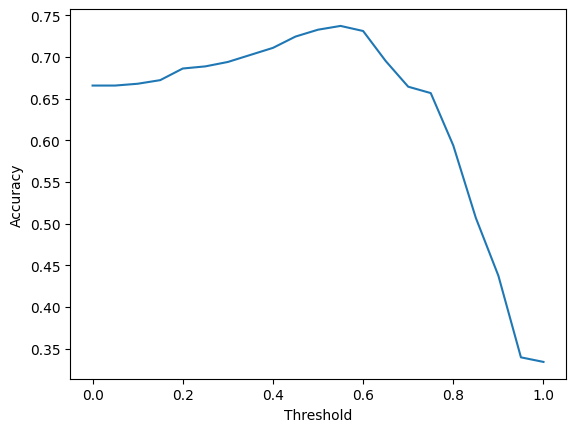

In [39]:
# Create a plot that shows how accuracy changes depending on the threshold
plt.plot(thresholds, scores)
plt.ylabel('Accuracy')
plt.xlabel('Threshold')

In [41]:
approval_outcome = (y_pred >= 0.56)
score = (y_val == approval_outcome).mean()
score

0.7379595046196187

Through experimentation with various thresholds between 0 and 1, we determined that a threshold of 0.56 yielded the highest accuracy (73.8%) for our logistic regression model on this specific dataset.

### Dummy Model

In [43]:
from collections import Counter

In [44]:
len(y_val)

5087

In [45]:
# Count # of Certified & Denied values in validation set
Counter(y_val)

Counter({1: 3387, 0: 1700})

In [46]:
y_val.mean()

0.6658148220955377

In [47]:
1 - y_val.mean()

0.33418517790446234

**Observations:**
* The baseline logistic regression model achieved an accuracy of 73.3%, which is only a slight improvement (6%) over a simple dummy model that always predicts "Certified." 
* This limited improvement suggests that the model may not be effectively capturing the underlying patterns in the data.

**Class Imbalance:**
* The dataset exhibits class imbalance, with approximately 67% of applications certified and 33% denied. 
* In such scenarios, accuracy can be a misleading metric. A model that simply predicts the majority class (in this case, "Certified") will achieve high accuracy without necessarily capturing meaningful relationships within the data.

### Baseline Model Evaluation Metrics

In [71]:
# Split the target variable y in validation set into certified and denied
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [72]:
# Split the predictions on validation set into certified and denied
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [73]:
# Combine prediction and actual into one and count how many of them
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [74]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[ 739,  961],
       [ 398, 2989]])

Now we know what kind of errors the model makes. We have more false positives than false negatives.

Two different types of errors, with false positives being more difficult to catch. 

In [75]:
# Instead of absolute numbers, we can have percentages
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.15, 0.19],
       [0.08, 0.59]])

**Model Misclassifications:**
- **False Positives:** The model predicts that an application will be certified, but it should be denied.
  - This can result in unqualified individuals filling positions that could be filled by qualified U.S. citizens, potentially leading to job displacement.
- **False Negatives:** The model predicts that an application will be denied, but it should be certified.
  - This can lead to the rejection of qualified and skilled foreign workers, potentially hindering economic growth and depriving the U.S. of valuable human resources.

**Importance of Minimizing Misclassifications:**

Both types of misclassifications have significant consequences.
- **False Positives:** Can lead to unfair competition for U.S. workers and potential security concerns.
- **False Negatives:** Can result in the loss of skilled labor and hinder economic growth.

**Addressing Misclassifications:**
- The F1 score is a valuable metric for evaluating the model's performance, as it considers both precision (minimizing false positives) and recall (minimizing false negatives).
- Higher F1 scores generally indicate better model performance in minimizing both types of misclassifications.

In [76]:
# Calculate accuracy
acc = (tp + tn) / (tp + tn + fp + fn)
acc

0.7328484371928445

In [77]:
# Calculate precision
p = tp / (tp + fp)
p

0.7567088607594936

In [78]:
1 - p

0.24329113924050638

Approximately 24% of the model's predictions are false positives, meaning the model incorrectly predicts that an application should be certified when it should actually be denied.

In [79]:
# Calculate recall
r = tp / (tp + fn)
r

0.8824918807204015

In [80]:
1 - r

0.11750811927959848

Our model failed to identify approximately 12% of applications that should have been certified (false negative rate of 12%).

While an overall accuracy of 73.3% might seem decent, it can be misleading due to class imbalance. A closer look at precision and recall reveals that our model exhibits strong performance in identifying true positives.

In [81]:
# Calculate f1 score
f1_score = 2 * p * r / (p + r)
f1_score

0.8147744309663351

With an F1-score of 0.81, the model demonstrates excellent performance. This high score reflects a strong balance between precision and recall, effectively identifying true positives while minimizing both false positives and false negatives. This indicates a highly accurate and reliable model for predicting visa application outcomes. 

In [82]:
from sklearn.metrics import roc_curve

In [83]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

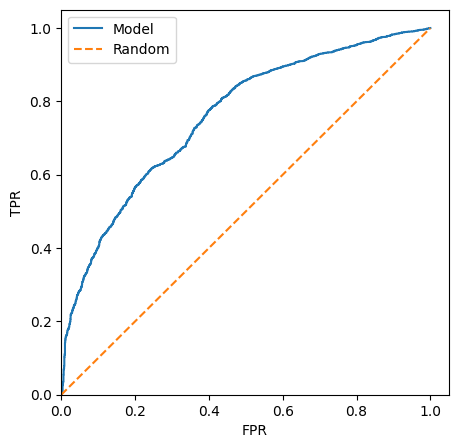

In [116]:
# Plot the ROC curves
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')
plt.xlim(xmin=0.0)
plt.ylim(ymin=0.0)

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

**Understanding model performance with ROC Curves**

ROC curves visualize how a model's performance changes as the classification threshold varies. At very high thresholds, all models tend to predict "Denied," leading to low True Positive Rates (TPR) and low False Positive Rates (FPR).

Good models exhibit a steep initial increase in TPR with minimal increase in FPR as the threshold decreases. This indicates a strong ability to correctly classify true positives while minimizing false positives. The ROC curve of a good model typically ascends sharply towards the top-left corner of the plot.

On the other hand, poor models demonstrate a rapid increase in FPR alongside TPR, indicating a higher rate of false positive predictions. The ROC curve of a poor model tends to have a shallower slope and may curve towards the right sooner.

In [88]:
from sklearn.metrics import roc_auc_score

In [114]:
auroc = roc_auc_score(y_val, y_pred)
auroc

0.7578002396707133

The baseline model exhibits an AUROC score of 0.7578. While this score is moderate, it suggests that the model may have limited ability to effectively differentiate between positive and negative instances.

In [112]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [93]:
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

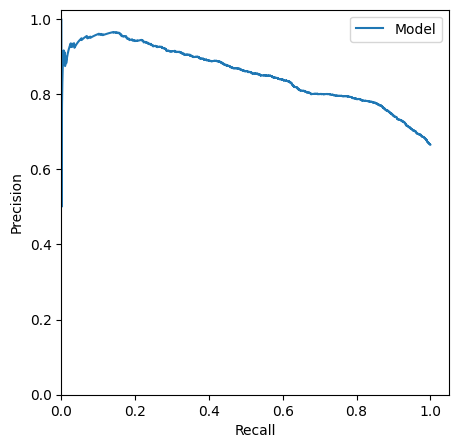

In [115]:
# Plot the PR curve
plt.figure(figsize=(5, 5))

plt.plot(recall, precision, label='Model')
plt.xlim(xmin=0.0)
plt.ylim(ymin=0.0)

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()
plt.show()

In [113]:
auprc = average_precision_score(y_val, y_pred)
auprc

0.8539331481681338

### Feature Extraction

#### Determine company age based on the current year and establishment year

In [ ]:
# Add a new column for company age
year = 2016
df_train['company_age'] = year - df_train['yr_of_estab']
df_val['company_age'] = year - df_val['yr_of_estab']

# Remove the year of establishment column
del df_train['yr_of_estab']
del df_val['yr_of_estab']

In [ ]:
df_train.head().T

In [ ]:
numerical = df_train.select_dtypes(exclude="object").columns
categorical = df_train.select_dtypes(include="object").columns

### Feature Transformation

In [ ]:
numerical

In [ ]:
# Plot distribution of numerical features before scaling
plt.figure(figsize=(12, 6))

colors = ['lightpink', 'paleturquoise', 'moccasin']

for i, feature in enumerate(numerical):
    plt.subplot(2, 2, i+1)
    # Plot the histogram
    sns.histplot(x=df_train[feature], color=colors[i])
    plt.xlabel(feature)
    plt.tight_layout()

plt.show()

In [ ]:
# Check Skewness
df_train[numerical].skew(axis=0)

#### Experiment with Yeo-Johnson transformation

In [ ]:
from sklearn.preprocessing import PowerTransformer

In [ ]:
transform_features = ['no_of_employees', 'company_age']

pt = PowerTransformer(method='yeo-johnson')
X_train_transformed = pt.fit_transform(df_train[transform_features])

In [ ]:
df_transformed = pd.DataFrame(X_train_transformed, columns=transform_features)

In [ ]:
# Plot distribution of numerical features after scaling
plt.figure(figsize=(12, 5))

colors = ['lightpink', 'moccasin']

for i, feature in enumerate(transform_features):
    plt.subplot(1, 2, i+1)
    # Plot the histogram
    sns.histplot(x=df_transformed[feature], color=colors[i])
    plt.xlabel(feature)
    plt.tight_layout()

plt.show()

In [ ]:
# Check Skewness
df_transformed.skew(axis=0)

#### Perform Feature Encoding and Scaling

In [ ]:
df_train.has_job_experience.head()

In [ ]:
# Replace Y/N with a number: 1 (Y) or 0 (N)
df_train.has_job_experience = (df_train.has_job_experience == 'Y').astype(int)
df_val.has_job_experience = (df_val.has_job_experience == 'Y').astype(int)
df_train.has_job_experience[:5]

In [ ]:
df_train.full_time_position.head()

In [ ]:
# Replace Y/N with a number: 1 (Y) or 0 (N)
df_train.full_time_position = (df_train.full_time_position == 'Y').astype(int)
df_val.full_time_position = (df_val.full_time_position == 'Y').astype(int)
df_train.full_time_position[:5]

In [ ]:
df_train.requires_job_training.head()

In [ ]:
# Replace Y/N with a number: 1 (Y) or 0 (N)
df_train.requires_job_training = (df_train.requires_job_training == 'Y').astype(int)
df_val.requires_job_training = (df_val.requires_job_training == 'Y').astype(int)
df_train.requires_job_training[:5]

In [ ]:
df_train.head()

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline

In [ ]:
# Create ColumnTransformer with 2 types of transformers
oh_columns = ['continent', 'unit_of_wage', 'region_of_employment', 'education_of_employee']
transform_columns= ['no_of_employees', 'company_age']

oh_transformer = OneHotEncoder()

transform_pipeline = Pipeline(steps=[
    ('transformer', PowerTransformer(method='yeo-johnson'))
])

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, oh_columns),
        ("Transformer", transform_pipeline, transform_columns),
        ("StandardScaler", numeric_transformer, numerical)
    ], remainder='passthrough'
)

In [ ]:
X_train = preprocessor.fit_transform(df_train)
X_train[0]

In [ ]:
X_train.shape

In [ ]:
preprocessor.get_feature_names_out()

In [ ]:
df_train.head(1)

In [ ]:
X_val = preprocessor.transform(df_val)
X_val[0]

In [ ]:
X_val.shape

In [ ]:

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, classification_report, ConfusionMatrixDisplay, precision_score, 
                            recall_score, f1_score, roc_auc_score, roc_curve) 
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [ ]:
def evaluate_clf(y, y_pred):
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    auroc = roc_auc_score(y, y_pred)
    return acc, f1 , precision, recall, auroc

In [ ]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(random_state=42), 
    "CatBoosting Classifier": CatBoostClassifier(random_state=42, verbose=False),
    "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier(random_state=42)
}

In [ ]:
# Evaluate models and return a report 
def evaluate_models(X_train, y_train, X_test, y_test, models):
    models_list = []
    accuracy_list = []
    f1_list = []
    auc_list = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        (model_train_accuracy, model_train_f1, model_train_precision,
        model_train_recall, model_train_auroc_score) = evaluate_clf(y_train ,y_train_pred)

        # Validation set performance
        (model_test_accuracy, model_test_f1, model_test_precision,
        model_test_recall, model_test_auroc_score) = evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance on Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- AUROC score: {:.4f}'.format(model_train_auroc_score))

        print('----------------------------------')

        print('Model performance on Validation set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print('- F1 score: {:.4f}'.format(model_test_f1))
        f1_list.append(model_test_f1)
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- AUROC score: {:.4f}'.format(model_test_auroc_score))
        auc_list.append(model_test_auroc_score)
        print('='*35)
        print('\n')
        
    report = pd.DataFrame(list(zip(models_list, accuracy_list, f1_list, auc_list)), 
                          columns=['Model Name', 'Accuracy', 'F1 Score', 'ROC AUC']).sort_values(by=['Accuracy'], 
                                                                                                 ascending=False)
        
    return report

In [ ]:
Counter(y_train)

In [ ]:
base_model_report = evaluate_models(X_train=X_train, y_train=y_train, 
                                    X_test=X_val, y_test=y_val, models=models)

In [ ]:
base_model_report

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
smt = SMOTE(random_state=42)
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

In [ ]:
Counter(y_train_sm)

In [ ]:
base_model_report = evaluate_models(X_train=X_train_sm, y_train=y_train_sm, 
                                    X_test=X_val, y_test=y_val, models=models)

In [ ]:
base_model_report

In [ ]:
from imblearn.over_sampling import ADASYN

In [ ]:
ada = ADASYN(random_state=42)
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)

In [ ]:
Counter(y_train_ada)

In [ ]:
base_model_report = evaluate_models(X_train=X_train_ada, y_train=y_train_ada, 
                                    X_test=X_val, y_test=y_val, models=models)

In [ ]:
base_model_report

In [ ]:
from imblearn.combine import SMOTETomek

In [ ]:
smtom = SMOTETomek(random_state=42)
X_train_smtom, y_train_smtom = smtom.fit_resample(X_train, y_train)

In [ ]:
Counter(y_train_smtom)

In [ ]:
base_model_report = evaluate_models(X_train=X_train_smtom, y_train=y_train_smtom, 
                                    X_test=X_val, y_test=y_val, models=models)

In [ ]:
base_model_report